## Setting The Scene

When running from Google Colab, we need to install Classiq's SDK and authenticate the remote device:

In [69]:
# !pip install -U classiq

In [70]:
# import classiq
# classiq.authenticate()

# Short introduction

### Classical encoders:
Refer to encoding/compressing classical data into a smaller sized data via deterministic algorithm. For example, JPEG is essentially an algorithm which compresses images into a smaller sized images.

### Classical auto-encoders:
One can use machine-learning technics and train a variational network for compressing data. In general, an auto-encoder network looks as follows:

<center>

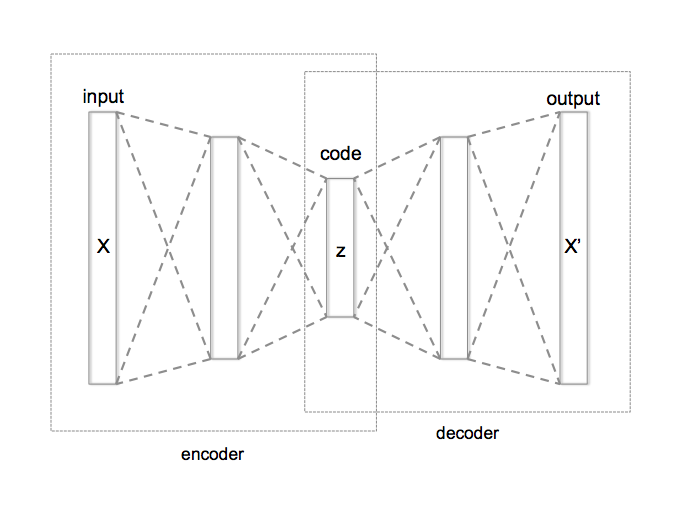
<!-- <img src="https://classiq-docs-images.s3.amazonaws.com/Autoencoder_structure.png" style="width:50%">![swap_test_closed.png](![swap_test_opened.png](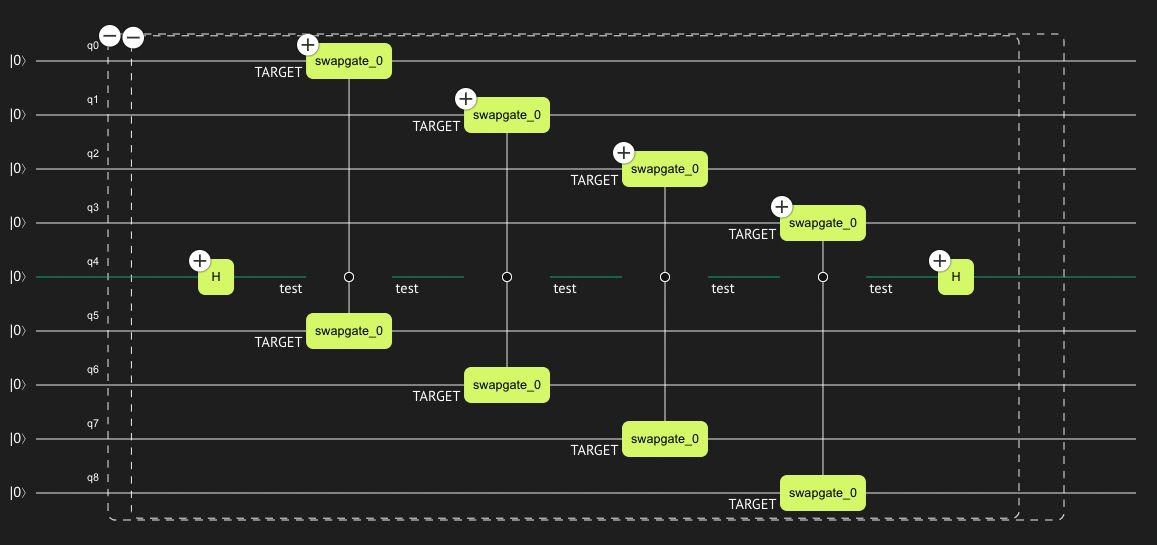
<figcaption align = "middle"> Classical auto encoder layout (taken from Wikipedia) </figcaption>
</center>
<!-- https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png -->

The network has three main parts: (1) The encoder part that compresses the data into a smaller, coded layer (2). The latter is the input to a decoder part (3). Typically, training is done against the comparison between the input and the output of this network.

**Classical auto encoders can also be used for anomaly detection (see below).**

### Quantum auto-encoders:
In a similar fashion to the classical counterpart, quantum auto-encoder refers to "compressing" quantum data stored initially on $n$ qubits into a smaller quantum register of $m<n$ qubits, via variational circuit. However, quantum computing is reversibale, and thus qubits cannot be "erased". Therefore, alternatively, a quantum autoencoder tries to acheive the following transformation from uncoded quantum register of size $n$ to a coded one of size $m$:
$$
|\psi\rangle_n \rightarrow |\psi'\rangle_m|0\rangle_{n-m}
$$
Namely, we try to decouple the initial state to a product state of a smaller register of size $m$ and a register which is in the zero state. The former is usually called *coded* state and the latter the *trash* state.

<!-- <center>

<img src="https://classiq-docs-images.s3.amazonaws.com/q_auto_encoder.png" style="width:100%">![Autoencoder_structure.png]()

<figcaption align = "middle"> Quantum auto encoder layout: uncoded data of size 5 transforms into two outputs, a coded register of size 3 and trash outputs of size 2 at state $|00\rangle$ </figcaption>
</center> -->

# Training of quantum auto encoders

To train a quantum auto encoder one should define a proper cost function. Below we propose two common approaches, one using a swap test and the other uses Hamiltonian measurements. We focus on the swap test case, and comment on the other approach at the end of this notebook.

## The swap test

The swap test is a quantum function which checks the overlap between two quantum states: the inputs of the function are two |quantum registers of the same size, $|\psi_1\rangle, \,|\psi_2\rangle$, and it returns as an output a single "test" qubit whose state encodes the overlap between the two inputs: $|q\rangle_{\rm test} = \alpha|0\rangle + \sqrt{1-\alpha^2}|1\rangle$, with
$$
\alpha^2 = \frac{1}{2}\left(1+|\langle \psi_1 |\psi_2 \rangle |^2\right).
$$
Thus, the probability to measure the test qubit at state $0$ is 1 if the states are identical (up to a global phase), and 0.5 if the states are orthogonal to each other.

The quantum model starts with an H gate on the test qubit, followed by swapping between the two states controlled on the test qubit, and a final H gate on the test qubit:






<center>

<table><tr>
<td>

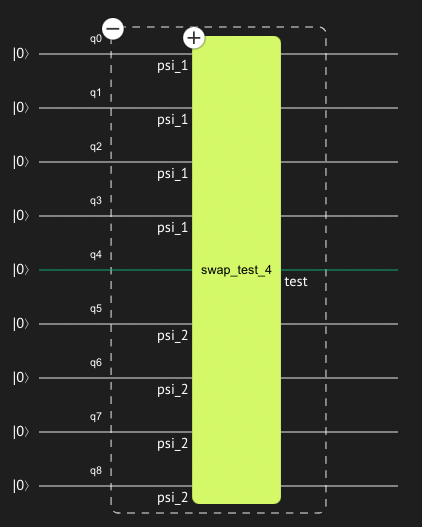

<!-- <img src="https://classiq-docs-images.s3.amazonaws.com/swap_test_closed.png" style="width:100%"> -->

<td>

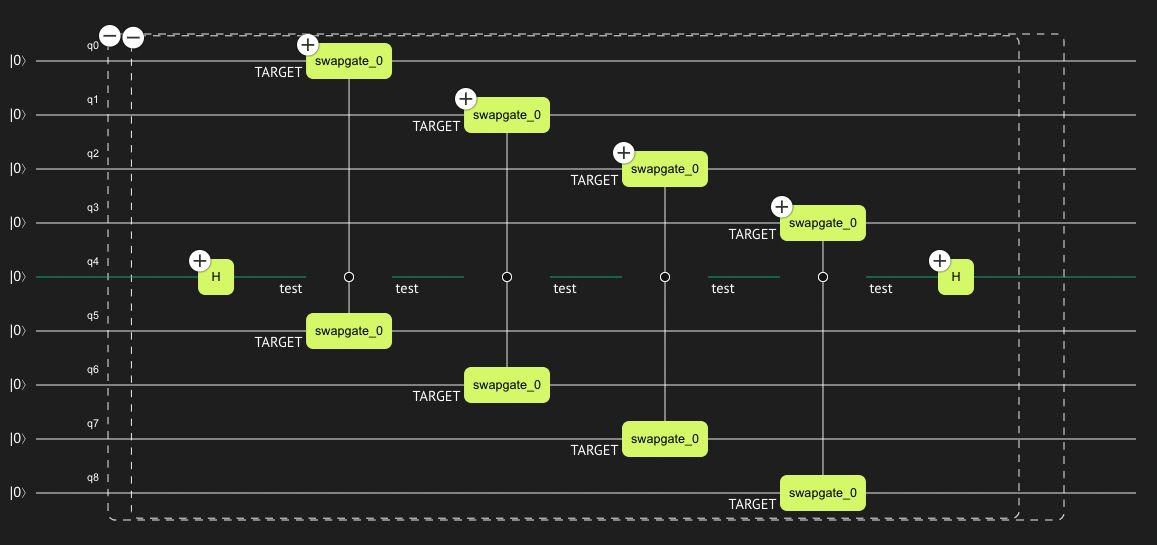


<!-- <img src="https://classiq-docs-images.s3.amazonaws.com/swap_test_opened.png" style="width:100%"> -->

</tr></table>
<figcaption align = "middle"> Closed (left panel) and opened (right panel) visualization of the swap test algorithm </figcaption>

</center>

## Quantum neural network for quantum auto encoder

The quantum auto encoder can be built as a quantum neural network, having the following three parts:

1. A data loading block that loads classical data on $n$ qubits.
2. An encoder block which is some variational quantum ansatz; input port of size $n$ and output ports of size $m$ and $n-m$.
3. A swap test block between the $n-m$ trash output of the encoder and new $n-m$ zero registers.

We train the network such that the test qubit of the swap test is at state |0⟩ with probability 1.
<center>

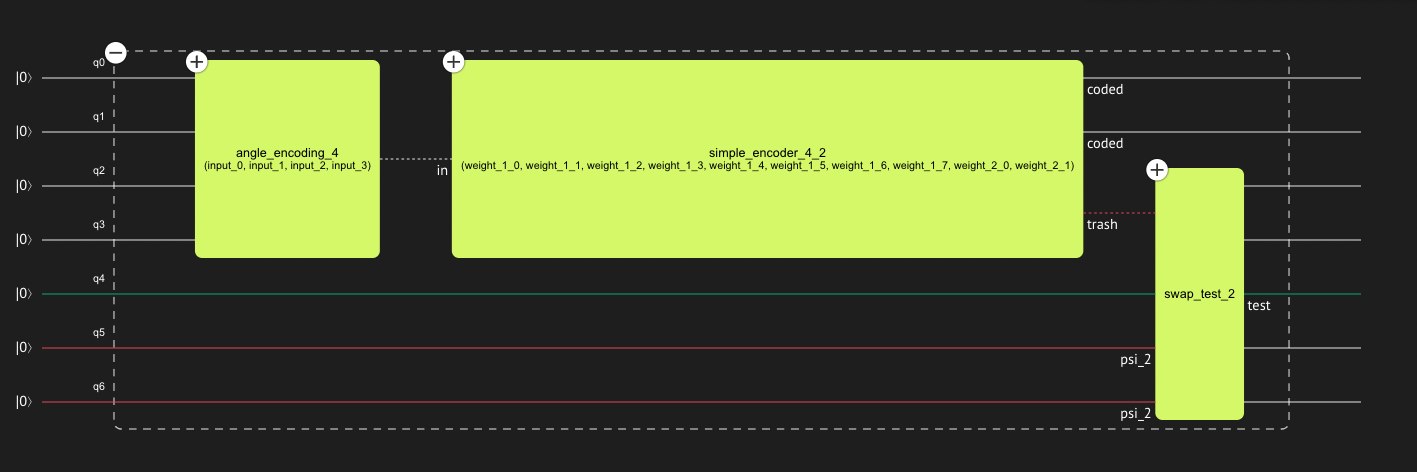
<!-- <img src="https://classiq-docs-images.s3.amazonaws.com/qae_qlayer.png" style="width:100%"> -->
<figcaption align = "middle">  Quantum auto encoder layout: uncoded data of size 4 transforms into two outputs, a coded register of size 2 and trash outputs of size 2 at state $|00\rangle$
</figcaption>
</center>

# Pre-user-defined functions which will be used to construct the quantum layer

As a first step we build some user-defined functions which allow us flexible modeling. We have three functions:
1. `angle_encoding`: This function loads data of size `num_qubits` on `num_qubits` qubits via RY gates. It has an output port named `qbv`.
2. `encoder_ansatz` : A simple variational ansatz for encoding `num_qubits` qubits on `num_encoding_qubits` qubits (see description within the code-block). The input port is `x`, and the output ports are `coded` and `trash`.

In [1]:
from classiq import (
    CX,
    RY,
    CArray,
    CInt,
    CReal,
    Input,
    Output,
    QArray,
    QBit,
    allocate,
    bind,
    create_model,
    qfunc,
    repeat,
)
from classiq.qmod.symbolic import pi

In [2]:
@qfunc
def angle_encoding(exe_params: CArray[CReal], qbv: Output[QArray[QBit]]) -> None:
    allocate(exe_params.len, qbv)
    repeat(
        count=exe_params.len,
        iteration=lambda index: RY(pi * exe_params[index], qbv[index]),
    )

In [3]:
@qfunc
def encoder_ansatz(
    num_qubits: CInt,
    num_encoding_qubits: CInt,
    exe_params: CArray[CReal],
    x: Input[QArray[QBit, "num_qubits"]],
    trash: Output[QArray[QBit, "num_qubits-num_encoding_qubits"]],
    coded: Output[QArray[QBit, "num_encoding_qubits"]],
) -> None:
    """
    This is a parametric model which has num_trash_qubits = num_qubits-num_encoding_qubits as an output.
    It contains num_trash_qubits layers, each composed of RY gates and CX gates with a linear connectivity,
    and a final layer with RY gate on each of the trash qubits is applied.
    """

    def single_layer(rep: CInt) -> None:
        repeat(
            count=num_qubits,
            iteration=lambda index: RY(exe_params[rep * num_qubits + index], x[index]), # What is the logic behind 1st arg of RY?
        )
        repeat(
            count=num_qubits - 1,
            iteration=lambda index: CX(x[index], x[index + 1]),
        )

    repeat(count=num_qubits - num_encoding_qubits, iteration=single_layer) # Could be lammbda func
    bind(x, [coded, trash])
    repeat(
        count=num_qubits - num_encoding_qubits,
        iteration=lambda index: RY(
            exe_params[(num_qubits - num_encoding_qubits) * num_qubits + index], # What is the logic behind 1st arg of RY?
            trash[index],
        ),
    )

# An example: auto encoder for domain wall data

In the following example we will try to encode data which has a domain wall structure. Let us define the relevant data for strings of size 4.

## The data

In [4]:
import numpy as np

domain_wall_data = np.array([[0, 0, 1, 1], [0, 0, 0, 1], [0, 1, 1, 1]])
print("domain wall data:")
domain_wall_data

domain wall data:


array([[0, 0, 1, 1],
       [0, 0, 0, 1],
       [0, 1, 1, 1]])

## The quantum program

We will try to encode this data on size 4 on 2 qubits. Let us built the corresponding quantum layer based on the pre-defined functions above.

In [5]:
from classiq import show, swap_test, synthesize

NUM_QUBITS = 4
NUM_ENCODING_QUBITS = 2
num_trash_qubits = NUM_QUBITS - NUM_ENCODING_QUBITS
num_weights_in_encoder = NUM_QUBITS * num_trash_qubits + num_trash_qubits

Let us construct the model

In [6]:
@qfunc
def main(
    w: CArray[CReal, num_weights_in_encoder],
    input: CArray[CReal, NUM_QUBITS],
    trash: Output[QArray[QBit, num_trash_qubits]],
    coded: Output[QArray[QBit, NUM_ENCODING_QUBITS]],
    test: Output[QBit],
) -> None:
    x = QArray("x")
    psi2 = QArray("psi2")
    allocate(num_trash_qubits, psi2)
    angle_encoding(exe_params=input, qbv=x)
    encoder_ansatz(
        num_qubits=NUM_QUBITS,
        num_encoding_qubits=NUM_ENCODING_QUBITS,
        exe_params=w,
        x=x,
        trash=trash,
        coded=coded,
    )

    swap_test(state1=trash, state2=psi2, test=test)


ae_qmod = create_model(main)

We synthesize and visualize the quantum layer:

In [7]:
qprog = synthesize(ae_qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/e9847937-addd-4146-ad82-aeb3e82f0cbf?version=0.42.0


## The network

The network for training contains only a quantum layer. The corresponding quantum program was already defined above, what is left is to define some execution preferences and the classical post-process. The classical output is defined as $1-\alpha^2$, with $\alpha$ being the probability of the test qubit to be at state 0.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from classiq.applications.qnn import QLayer
from classiq.applications.qnn.types import (
    MultipleArguments,
    ResultsCollection,
    SavedResult,
)
from classiq.execution import (
    ExecutionPreferences,
    execute_qnn,
    set_quantum_program_execution_preferences,
)
from classiq.synthesis import SerializedQuantumProgram

In [9]:
num_shots = 4096


def execute(
    quantum_program: SerializedQuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    quantum_program = set_quantum_program_execution_preferences(
        quantum_program, preferences=ExecutionPreferences(num_shots=num_shots)
    )
    return execute_qnn(quantum_program, arguments)


def post_process(result: SavedResult) -> torch.Tensor:
    alpha_sqaured = result.value.counts_of_output("test")["0"] / num_shots
    out = 1 - alpha_sqaured
    return torch.tensor(out)

In [10]:
def create_net(*args, **kwargs) -> nn.Module:
    class Net(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__()

            self.qlayer = QLayer(
                qprog,
                execute,
                post_process,
                *args,
                **kwargs,
            )

        def forward(self, x):
            x = self.qlayer(x)
            return x

    return Net(*args, **kwargs)


encoder_train_network = create_net()

## Creating dataset

The cost function we would like to minimize is $|1-\alpha^2|$ for all our training data. Looking at the qlayer output this means that we should define the corresponding labels as $0$.

In [81]:
class MyDWDataset:
    def __init__(self, data, labels) -> None:
        self.data = torch.from_numpy(data).float()
        self.labels = torch.unsqueeze(torch.from_numpy(labels), dim=-1).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [82]:
labels = np.array([0, 0, 0])
train_dataset = MyDWDataset(domain_wall_data, labels)
train_data_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, drop_last=False
)

## Define the training

In [160]:
import time as time


def train(
    model: nn.Module,
    data_loader: DataLoader,
    loss_func: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epoch: int = 40,
) -> None:
    for index in range(epoch):
        start = time.time()
        for data, label in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(torch.squeeze(output), torch.squeeze(label))
            loss.backward()
            optimizer.step()

        print(time.time() - start) # Prints time per step
        print(index, f"\tloss = {loss.item()}")

## Setting some hyper-parameters

The L1 loss function fits the intended cost function we aim to minimize.

In [171]:
_LEARNING_RATE = 0.03
loss_func = nn.L1Loss()
optimizer = optim.SGD(encoder_train_network.parameters(), lr=_LEARNING_RATE)
# optimizer = optim.SGD(encoder_train_network.parameters(), lr=_LEARNING_RATE, momentum=0.9)
# optimizer = optim.Adam(encoder_train_network.parameters(), lr=_LEARNING_RATE)

## Training

In this demo we will initialize the network with trained parameters, and run only 1 epoch for demonstration. A reasonable training with the above hyper-parameters can be achieved with $\sim 40$ epochs. To train the network from the beginning uncomment the following code line:

In [172]:
trained_weights = torch.nn.Parameter(
    torch.Tensor(
        [1.5227, 0.3588, 0.6905, 1.4777, 1.5718, 1.5615, 1.5414, 0.6021, 0.1254, 0.9903]
    )
)

# trained_weights = torch.nn.Parameter(torch.rand(10)) # if uncomment parameters will be prepared for training from scratch


encoder_train_network.qlayer.weight = trained_weights

In [173]:
data_loader = train_data_loader

train(encoder_train_network, data_loader, loss_func, optimizer, epoch=5)

9.504712343215942
0 	loss = 0.9384765625
9.940344333648682
1 	loss = 0.8662109375
8.715864419937134
2 	loss = 0.9384765625
8.663626194000244
3 	loss = 0.8662109375
8.422551393508911
4 	loss = 0.8662109375
10.218191146850586
5 	loss = 1.5341796875
8.701385498046875
6 	loss = 0.9384765625
8.76116394996643
7 	loss = 0.8662109375
8.970725297927856
8 	loss = 1.5341796875
8.719649314880371
9 	loss = 0.8662109375
10.413763761520386
10 	loss = 0.9384765625
9.923221111297607
11 	loss = 0.9384765625
9.860797882080078
12 	loss = 0.8662109375
8.769683361053467
13 	loss = 0.9384765625
8.7511465549469
14 	loss = 1.5341796875
8.806759119033813
15 	loss = 0.8662109375
8.751865863800049
16 	loss = 0.9384765625
8.84875226020813
17 	loss = 0.8662109375
8.649004459381104
18 	loss = 0.9384765625
8.527371168136597
19 	loss = 1.5341796875
8.607317924499512
20 	loss = 0.9384765625
8.692336320877075
21 	loss = 1.5341796875
8.559823036193848
22 	loss = 0.8662109375
8.736822366714478
23 	loss = 0.9384765625
8.55

## Verification

Once we trained our network, we can build a new network with the trained variables. We can thus verify our encoder by taking only the encoding block, changing post_process, etc.

Below we verify our quantum auto encoder by comparing between input and output of an encoder-decoder network:

We will create the following network, which contains two quantum blocks:
* The first two blocks of the previous network: a block for loading the inputs followed by our quantum encoder.
* The inverse of the quantum encoder, where the inputs for the trash qubits are new zero inputs.

**The network's weights will be allocated with the trained ones**

<center>

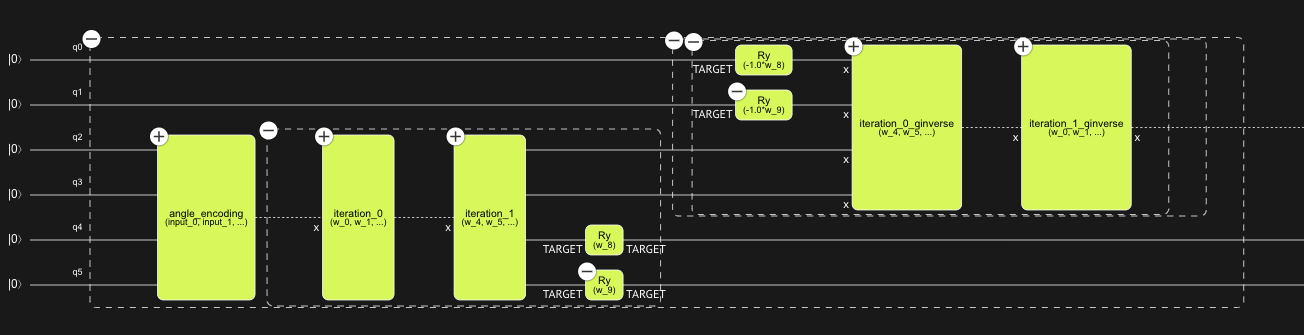

<!-- <img src="https://classiq-docs-images.s3.amazonaws.com/encoder_decoder.png" style="width:100%"> -->
<figcaption align = "middle"> QLayer for verifying quantum auto encoder, containing three quantum blocks: (1) data encoding, (2) trained encoder, and (3) inverse of trained encoder (i.e., decoder). </figcaption>
</center>

### We start with building the quantum layer for the validator

The validator contains the inverse of our encoder, for this, we will have to wrap our encoder function. This is because the `invert` quantum function except a single inout port.

In [145]:
@qfunc
def encoder_ansatz_wrapper(
    num_qubits: CInt,
    num_encoding_qubits: CInt,
    exe_params: CArray[CReal],
    qbv: QArray[QBit, "num_qubits"],
) -> None:
    coded = QArray("coded")
    trash = QArray("trash")
    encoder_ansatz(
        num_qubits=num_qubits,
        num_encoding_qubits=num_encoding_qubits,
        exe_params=exe_params,
        x=qbv,
        trash=trash,
        coded=coded,
    )
    bind([coded, trash], qbv)

We are now ready for modeling our verification quantum layer

In [146]:
from classiq import invert


@qfunc
def main(
    w: CArray[CReal, num_weights_in_encoder],
    input: CArray[CReal, NUM_QUBITS],
    decoded: Output[QArray[QBit, NUM_QUBITS]],
    trash: Output[QArray[QBit, num_trash_qubits]],
) -> None:
    psi2 = QArray("psi2")
    coded = QArray("coded")
    allocate(num_trash_qubits, psi2)
    angle_encoding(exe_params=input, qbv=decoded)
    encoder_ansatz(
        num_qubits=NUM_QUBITS,
        num_encoding_qubits=NUM_ENCODING_QUBITS,
        exe_params=w,
        x=decoded,
        trash=trash,
        coded=coded,
    )

    bind([coded, psi2], decoded)
    invert(
        operand=lambda: encoder_ansatz_wrapper(
            num_qubits=NUM_QUBITS,
            num_encoding_qubits=NUM_ENCODING_QUBITS,
            exe_params=w,
            qbv=decoded,
        ),
    )


validator_qmod = create_model(main)

In [147]:
validator_qprog = synthesize(validator_qmod)
show(validator_qprog)

Opening: https://platform.classiq.io/circuit/ce332293-cc22-4da0-a755-e9b304aaa55f?version=0.41.2


### Next, we define the classical output of the network. For the validator post-process we take the output with the maximal counts.

In [148]:
def execute_validator(
    quantum_program: SerializedQuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    return execute_qnn(quantum_program, arguments)

In [149]:
def post_process_validator(result: SavedResult) -> torch.Tensor:
    counts = result.value.counts_of_output("decoded")

    max_key = max(counts, key=counts.get)
    # print(counts)
    return torch.tensor([int(k) for k in max_key])

### We create the network and assign the trained parameters

In [150]:
def create_encoder_decoder_net(*args, **kwargs) -> nn.Module:
    class Net(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__()

            self.qlayer = QLayer(
                validator_qprog,
                execute_validator,
                post_process_validator,
                *args,
                **kwargs,
            )

        def forward(self, x):
            x = self.qlayer(x)
            return x

    return Net(*args, **kwargs)


validator_network = create_encoder_decoder_net()
validator_network.qlayer.weight = encoder_train_network.qlayer.weight

Now we can compare between the input and output of the validator, for each different data:

In [151]:
validator_data_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True, drop_last=False
)

for data, label in validator_data_loader:
    output = validator_network(data)
    print("input=", data.tolist()[0], ",   output=", output.tolist()[0])

input= [0.0, 0.0, 0.0, 1.0] ,   output= [0.0, 0.0, 0.0, 0.0]
input= [0.0, 1.0, 1.0, 1.0] ,   output= [0.0, 1.0, 0.0, 1.0]
input= [0.0, 0.0, 1.0, 1.0] ,   output= [0.0, 0.0, 0.0, 0.0]


# Usage for anomaly detection

We can use our trained network for anomaly detection. Let see what happens to the trash qubits when we insert anomaly, namely, a non domain-wall data:

In [94]:
input_anomaly_data = np.array(
    [[0, 0, 1, 1], [0, 0, 0, 1], [0, 0, 1, 1], [1, 0, 1, 0], [1, 1, 1, 1]]
)
anomaly_labels = np.array([0, 0, 0, 0, 0])
anomaly_dataset = MyDWDataset(input_anomaly_data, anomaly_labels)
anomaly_data_loader = DataLoader(
    anomaly_dataset, batch_size=1, shuffle=True, drop_last=False
)

We print all the anomaly data based on some pre-defined accuracy for the cost function:

In [95]:
tolerance = 1e-2
for data, label in anomaly_data_loader:
    output = encoder_train_network(data)
    if abs(output.tolist()[0]) > tolerance:
        print("anomaly:", data.tolist()[0])

anomaly: [0.0, 0.0, 0.0, 1.0]
anomaly: [1.0, 0.0, 1.0, 0.0]
anomaly: [1.0, 1.0, 1.0, 1.0]
anomaly: [0.0, 0.0, 1.0, 1.0]
anomaly: [0.0, 0.0, 1.0, 1.0]


# Alternative network for training a quantum auto encoder

Another way to introduce a cost function is via estimation of Hamiltonians. Measuring the Pauli $Z$ matrix on a qubit at the general state $|q\rangle=a|0\rangle+b|1\rangle$ is $\langle q |Z|q \rangle=a^2-b^2$. Therefore, a cost function can be defined by taking expectation values on the trash output (without a swap-test) as follows:
$$
\text{Cost} = \frac{1}{2}\sum^{\text{num of trash qubits}}_{k=1} 1 - \langle Z_k \rangle.
$$

Below we show how the define the corresponding Qlayer: the quantum program and post-processing:

## The quantum program

In [96]:
@qfunc
def main(
    w: CArray[CReal, num_weights_in_encoder],
    input: CArray[CReal, NUM_QUBITS],
    trash: Output[QArray[QBit, num_trash_qubits]],
) -> None:
    x = QArray("x")
    coded = QArray("coded")
    angle_encoding(exe_params=input, qbv=x)
    encoder_ansatz(
        num_qubits=NUM_QUBITS,
        num_encoding_qubits=NUM_ENCODING_QUBITS,
        exe_params=w,
        x=x,
        trash=trash,
        coded=coded,
    )


ae_qmod = create_model(main)


qprog = synthesize(ae_qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/e4318b40-1f0e-4a80-9003-41ea4a335cd9?version=0.41.2


## Execution and post-process

The trash register is of size 2, we measure the Pauli $Z$ matrix on each of its qubits

In [97]:
from classiq.applications.chemistry import PauliOperator, PauliOperators


def execute(
    quantum_program: SerializedQuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    return execute_qnn(
        quantum_program,
        arguments,
        observable=PauliOperator(pauli_list=[("IZ", 1), ("ZI", 1)]),
    )


def post_process(result: SavedResult) -> torch.Tensor:
    out = 1 / 2 * (2 - np.real(result.value.value))
    return torch.tensor(out)

In [98]:
def create_net(*args, **kwargs) -> nn.Module:
    class Net(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__()

            self.qlayer = QLayer(
                qprog,
                execute,
                post_process,
                *args,
                **kwargs,
            )

        def forward(self, x):
            x = self.qlayer(x)
            return x

    return Net(*args, **kwargs)


encoder_train_network = create_net()